In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)
warnings.filterwarnings("ignore")

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


# Assumption One: Linear Relationship
Plot residual vs predicted for each independent variable. Attempt to make each variable homoscedastic.

In [3]:
def ind_var_lg(ind_var, dep_var, func_name = ''):
    single_X = ind_var.reshape(-1, 1) # reshape because its a single feature
    single_Y = dep_var.reshape(-1,1)
    lg_model = linear_model.LinearRegression()
    lg_model.fit(single_X, single_Y)
    predicted = lg_model.predict(single_X).ravel().reshape(-1,1)
    residual = single_Y - predicted
    r2 = lg_model.score(single_X, single_Y)
    print ("{} R2 score: {}".format(func_name,r2))
    _, ax_lg = plt.subplots(1,2, figsize = (15,3))
    sns.regplot(predicted, residual, fit_reg=False, ax = ax_lg[0]).set_title("Residuals: " + ind_var.name + " " + func_name)
    ax_lg[0].axhline(0, linestyle = '--', color = 'k')
    sns.regplot(single_X, dep_var, ax = ax_lg[1]).set_title(" " + ind_var.name + " " + func_name)
    plt.show()

### TV

 R2 score: 0.611875050850071


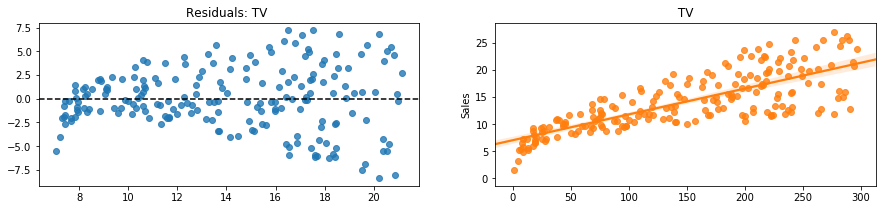

In [4]:
ind_var_lg(X['TV'], data['Sales'])

Square Root(TV) and Square Root(Sales) R2 score: 0.6731729213452803


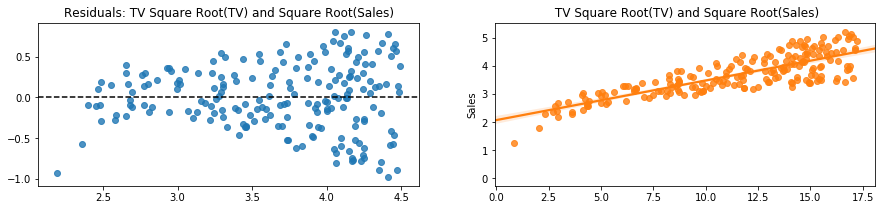

Log(Sales) R2 score: 0.6155986180925455


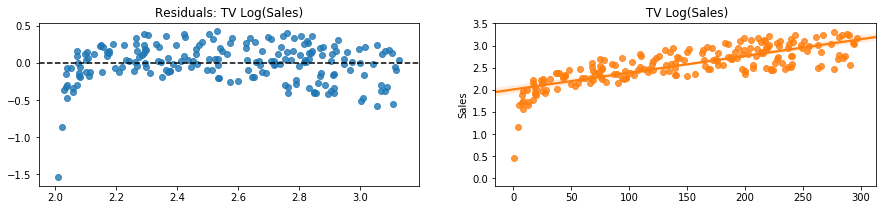

Log(TV) and Log(Sales) R2 score: 0.7421363059546486


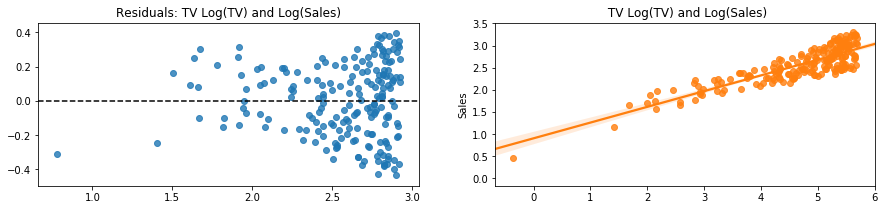

In [5]:
# transform TV and Sales by sqrt
ind_var_lg(X['TV'].apply(np.sqrt), data['Sales'].apply(np.sqrt), 'Square Root(TV) and Square Root(Sales)')
# transform Sales by log
ind_var_lg(X['TV'], data['Sales'].apply(np.log), 'Log(Sales)')
# transform TV and Sales by log
ind_var_lg(X['TV'].apply(np.log), data['Sales'].apply(np.log), 'Log(TV) and Log(Sales)')

### Radio

 R2 score: 0.33203245544529525


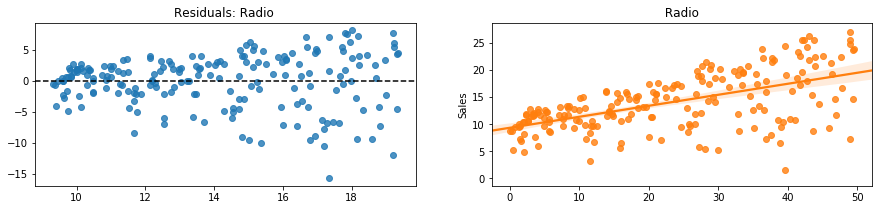

In [6]:
ind_var_lg(X['Radio'], data['Sales'])

Square Root(Radio) and Square Root(Sales) R2 score: 0.28343813613617197


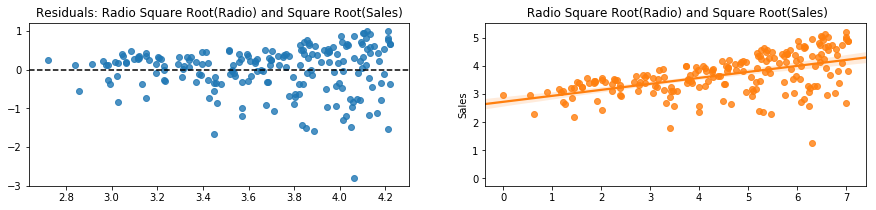

Log(Sales) R2 score: 0.22198296259795636


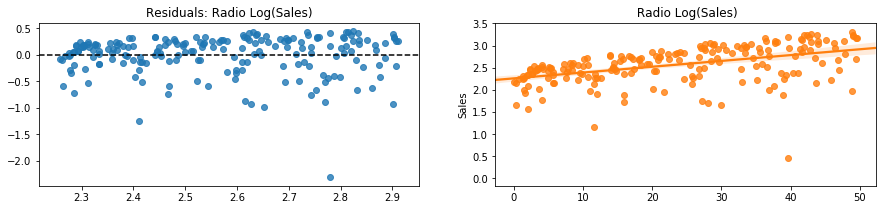

Log(Radio) and Log(Sales) R2 score: 0.20486292120152028


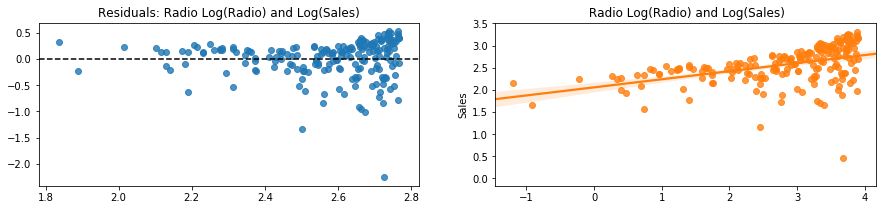

In [7]:
# transform Radio and Sales by sqrt
ind_var_lg(X['Radio'].apply(np.sqrt), data['Sales'].apply(np.sqrt), 'Square Root(Radio) and Square Root(Sales)')
# transform Sales by log
ind_var_lg(X['Radio'], data['Sales'].apply(np.log), 'Log(Sales)')
# transform Radio and Sales by log
ind_var_lg(X['Radio'][X['Radio'] > 0].apply(np.log), data['Sales'][X['Radio'] > 0].apply(np.log), 'Log(Radio) and Log(Sales)')

### Newspaper

 R2 score: 0.05212044544430516


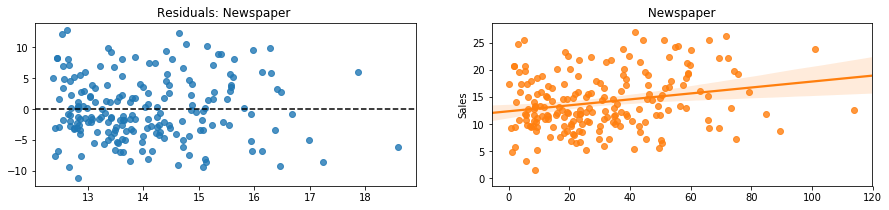

In [8]:
ind_var_lg(X['Newspaper'], data['Sales'])

Square Root(Newspaper) and Square Root(Sales) R2 score: 0.0406450773414363


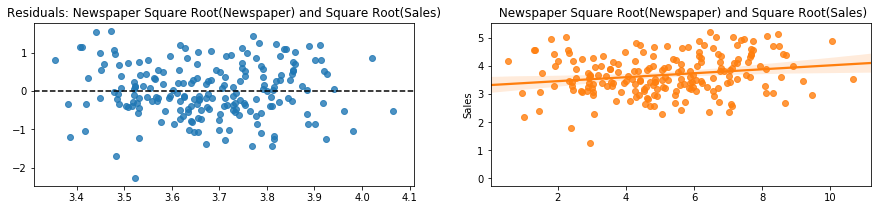

Log(Sales) R2 score: 0.04470795153998486


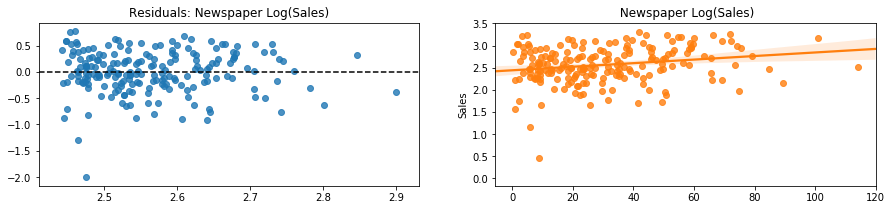

Log(Newspaper) and Log(Sales) R2 score: 0.025171585239625816


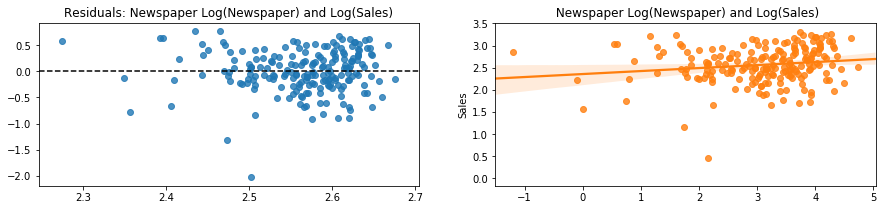

In [9]:
# transform Newspaper and Sales by sqrt
ind_var_lg(X['Newspaper'].apply(np.sqrt), data['Sales'].apply(np.sqrt), 'Square Root(Newspaper) and Square Root(Sales)')
# transform Sales by log
ind_var_lg(X['Newspaper'], data['Sales'].apply(np.log), 'Log(Sales)')
# transform Newspaper and Sales by log
ind_var_lg(X['Newspaper'].apply(np.log), data['Sales'].apply(np.log), 'Log(Newspaper) and Log(Sales)')

# Assumption Two: Multivariate Normality
Test residual histogram for normality. Fix skewness or outliers in residual by fixing skewness or outliers in data

R2 score: 0.9730806537777336


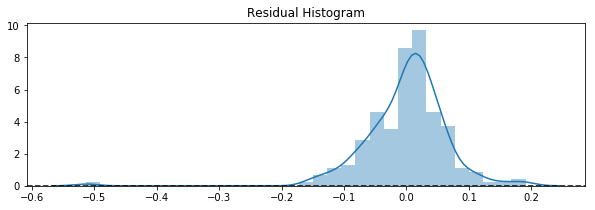

In [10]:
# prepare X and Y
A2_X = X.copy()
A2_X['log_tv'] = X['TV'].apply(np.log)
A2_X.drop('TV', axis = 1, inplace = True)
A2_Y = data['Sales'].apply(np.log).values.reshape(-1,1)
# fit the model
A2_lg_model = linear_model.LinearRegression()
A2_lg_model.fit(A2_X, A2_Y)
A2_predicted = A2_lg_model.predict(A2_X).ravel().reshape(-1,1)
A2_residual = A2_Y - A2_predicted
A2_r2 = A2_lg_model.score(A2_X, A2_Y)
print ("R2 score: {}".format(A2_r2))
# plot residual and histogram
plt.figure(figsize = (10,3)); 
sns.distplot(A2_residual).set_title('Residual Histogram')
plt.axhline(0, linestyle = '--', color = 'k')
plt.show()

In [11]:
# find what conditions cause the outlier at -0.5
# predicted < 1
outlier_index = np.where(A2_predicted < 1.0)
print ("predicted: {}\nactual: {}".format(A2_predicted[outlier_index[0][0]], A2_Y[outlier_index[0][0]]))
display(data.loc[data['Sales'] == np.exp(A2_Y[outlier_index[0][0]][0])])

predicted: [0.98337662]
actual: [0.47000363]


,Unnamed: 0,TV,Radio,Newspaper,Sales
130,131,0.700,39.600,8.700,1.600


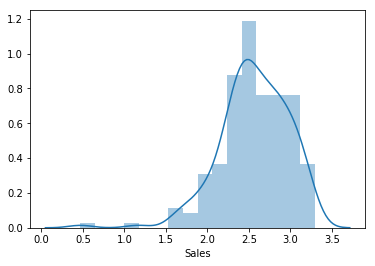

In [12]:
# plot distribution of log(Sales)
sns.distplot(data['Sales'].apply(np.log))
plt.show()

### Assumption Three: Homoscedasticity
Look at the residual vs predicted plot. Fix unbalanced variance by targeting poorly estimated areas.

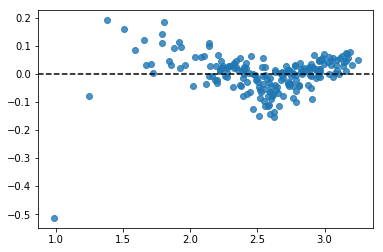

In [13]:
sns.regplot(A2_predicted,A2_residual, fit_reg = False)
plt.axhline(0, linestyle = '--', color = 'k')
plt.show()

In [14]:
# drop log(Sales) below 1.0 or Sales below 3.0
A3_df = data.copy()
indices_drop = A3_df[A3_df['Sales'] < 3.0]
display(indices_drop)
A3_no_outliers = A3_df.drop(indices_drop.index, axis = 0)

,Unnamed: 0,TV,Radio,Newspaper,Sales
130,131,0.700,39.600,8.700,1.600


In [15]:
A3_X = A3_no_outliers[['TV', 'Radio', 'Newspaper']]
A3_X['log_tv'] = A3_X['TV'].apply(np.log)
A3_X.drop('TV', axis = 1, inplace = True)
A3_Y = A3_no_outliers['Sales']
A3_Y = A3_Y.apply(np.log).reshape(-1,1)

R2 score: 0.9794420368317874


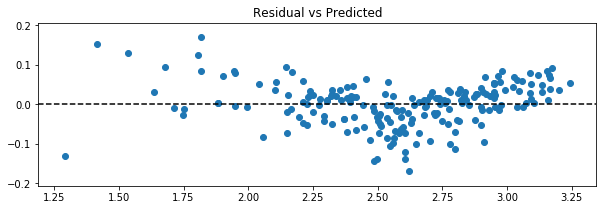

In [26]:
# fit the model
A3_lg_model = linear_model.LinearRegression()
A3_lg_model.fit(A3_X, A3_Y)
A3_predicted = A3_lg_model.predict(A3_X).ravel().reshape(-1,1)
A3_residual = A3_Y - A3_predicted
A3_r2 = A3_lg_model.score(A3_X, A3_Y)
print ("R2 score: {}".format(A3_r2))
# plot residual and histogram
plt.figure(figsize = (10,3)); 
plt.scatter(A3_predicted, A3_residual)
plt.title('Residual vs Predicted')
plt.axhline(0, linestyle = '--', color = 'k')
plt.show()

### Assumption Four: Multicollinearity
Plot a correlation matrix. Fix by throwing out highly correlated independent variables, or transforming until not correlated.

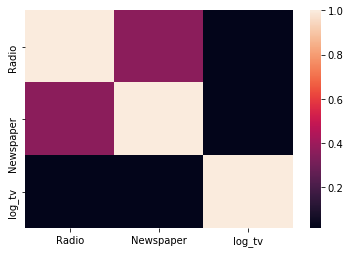

,Radio,Newspaper,log_tv
Radio,1.000,0.362,0.018
Newspaper,0.362,1.000,0.016
log_tv,0.018,0.016,1.000


In [29]:
sns.heatmap(A3_X.corr())
plt.show()
display(A3_X.corr())